In [1]:
import locale
locale.setlocale(locale.LC_ALL,'en_US')

import pandas
import collections
import itertools
import numpy as np
import lifelines

from matplotlib import pyplot as plt

import matplotlib_venn
import seaborn
seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')

%matplotlib inline

In [2]:
FIG_SIZE = (5, 3)

In [3]:
data = pandas.read_csv('../data/github-cran-150601.csv', index_col=0)

data['Date'] = pandas.to_datetime(data['Date'])
data['Dependencies'] = data['Dependencies'].map(lambda x: [] if pandas.isnull(x) else x.split(' '))

data = data[['Package', 'Version', 'Date', 'InCRAN', 'InGitHub', 'Dependencies']]
alldata = data.copy()

In [4]:
_github = data.query('InGitHub == 1')
_cran = data.query('InCRAN == 1')

_archived = pandas.read_csv('../data/cran-packages-150601.csv')
_archived = _archived.query('archived == False').rename(columns={'package': 'Package'})

_cran = _cran.merge(_archived[['Package']], how='inner', on=['Package'])
data = pandas.concat([_github, _cran])

In [5]:
# README
readme = pandas.read_csv('../data/readme.csv', index_col=0)

In [6]:
COLUMNS = ['install_github', 'install_packages']
data_readme = readme[['Package'] + COLUMNS].replace('[]', pandas.np.nan)

data_grep = pandas.DataFrame(index=data_readme['Package'])
for column in COLUMNS:
    _ = data_readme[['Package', column]].dropna().drop_duplicates().set_index('Package')
    data_grep = data_grep.join(_)
data_grep = data_grep.reset_index().drop_duplicates('Package').set_index('Package')

In [7]:
cran_packages = set(data.query('InCRAN == 1')['Package'])
github_packages = set(data.query('InGitHub == 1')['Package'])
both_packages = cran_packages.intersection(github_packages)

def where_to_find(row):
    if row['Package'] in both_packages:
        return 'both'
    elif row['Package'] in cran_packages:
        return 'cran'
    elif row['Package'] in github_packages:
        return 'github'
    else:
        return 'error'

packages = data.sort('Date').drop_duplicates(['Package', 'InCRAN'], take_last=True)
packages['Where'] = packages.apply(where_to_find, axis=1)
packages = packages.drop_duplicates('Package')

In [8]:
print len(cran_packages), len(github_packages), len(both_packages)
print packages.groupby('Where').count()

6706 4512 910
        Package  Version  Date  InCRAN  InGitHub  Dependencies
Where                                                         
both        910      910   910     910       910           910
cran       5796     5796  5796    5796      5796          5796
github     3602     3602  3602    3602      3602          3602


In [9]:
df = packages.set_index('Package')[['Date', 'Where']].join(data_grep)
df = df.query('Where != "cran"')
df['how_to_gh'] = df['install_github'].notnull()
df['how_to_cran'] = df['install_packages'].notnull()

In [15]:
for name, group in df.groupby('Where'):
    print 'Where:', name
    print '  Size: %d (%.3f%%)' % (len(group), len(group)*100.0 / len(df))
    _gh = group.query('how_to_gh == True')
    print '  How-To GitHub: %d (%.3f%%)' % (len(_gh), len(_gh) * 100.0 / len(group))
    
    _cran = group.query('how_to_cran == True')
    print '  How-To CRAN: %d (%.3f%%)' % (len(_cran), len(_cran) * 100.0 / len(group))
    
    _both = group.query('how_to_cran == True and how_to_gh == True')
    print '  How-To both: %d (%.3f%%)' % (len(_both), len(_both) * 100.0 / len(group))

Where: both
  Size: 910 (20.168%)
  How-To GitHub: 409 (44.9%)
  How-To CRAN: 332 (36.484%)
  How-To both: 291 (31.978%)
Where: github
  Size: 3602 (79.832%)
  How-To GitHub: 1438 (39.9%)
  How-To CRAN: 793 (22.016%)
  How-To both: 762 (21.155%)


In [11]:
print 100.0 * len(df.query('how_to_gh == True')) / len(df)

40.9352836879


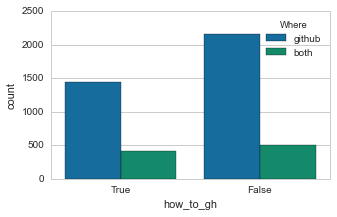

In [12]:
fig, ax = plt.subplots(figsize=FIG_SIZE)

# Counts
seaborn.countplot(hue='Where', x='how_to_gh', data=df, ax=ax)

(0, 1000)

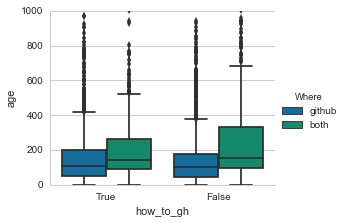

In [13]:
df['age'] = (pandas.Timestamp('2015-06-01') - df['Date']).dt.days

facet = seaborn.factorplot('how_to_gh', 'age', 'Where', data=df, kind='box')
facet.fig.set_size_inches(FIG_SIZE)
facet.ax.set_ylim(0,1000)